# Exploratory Data Analysis

### Imports

In [2]:
import matplotlib
import pandas as pd
import re

### Loading Data

#### Let's take a look at the small dataset

In [6]:
!ls ../data/ml-latest-small

README.txt  links.csv   movies.csv  ratings.csv tags.csv


In [7]:
links = pd.read_csv('../data/ml-latest-small/links.csv')
movies = pd.read_csv('../data/ml-latest-small/movies.csv')
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
tags = pd.read_csv('../data/ml-latest-small/tags.csv')

In [8]:
print(f"""We have the following shapes:
        Links: {links.shape}
        movies: {movies.shape}
        ratings: {ratings.shape}
        tags: {tags.shape}""")

We have the following shapes:
        Links: (9742, 3)
        movies: (9742, 3)
        ratings: (100836, 4)
        tags: (3683, 4)


#### Links

In [9]:
links.head(2)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


`links.csv` gives us a mapping of `movieId` with the ids from external sources (IMDB, TMDB)

#### Movies

In [10]:
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


Since the year of release comes indicated in the title, we will extract that info to another column in case it can help us in the future

In [11]:
def extract_date(title:str) -> int:
    title = ' '.join(title.split())
    if re.match(r'.*\([0-9]{4}\)$', title):
        try:
            return int(title[-5:-1])
        except:
            pass
    return 0

In [12]:
movies['release_year'] = movies.title.apply(lambda film: extract_date(film))

In [13]:
movies.head(2)

,movieId,title,genres,release_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995


Let's check if we have any film without `release_year`

In [20]:
print(f"There're {len(movies.query('release_year==0'))} films without year")

There're 13 films without year


<AxesSubplot:ylabel='Frequency'>

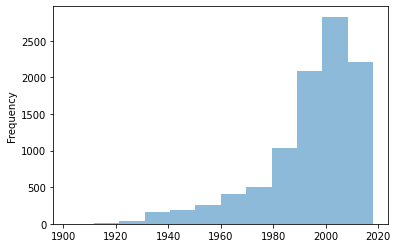

In [22]:
movies.loc[movies.release_year>0].release_year.plot.hist(bins=12, alpha=0.5)

Let's take a look at the genres

In [23]:
def parse_genres(genres_str: str) -> list:
    genres = genres_str.split('|')
    return genres

In [24]:
movies['genres'] = movies.genres.apply(lambda genres_str: parse_genres(genres_str))

In [25]:
movies.head(2)

,movieId,title,genres,release_year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995


So we have the following genres

In [29]:
pd.Series(sum([item for item in movies.genres], [])).value_counts()

Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
dtype: int64

#### Ratings

Apparently, each row of this DF consists on the review (`rating`) that a user (`userId`) makes of a movie (`movieId`) at a specific time (`timestamp`)

In [30]:
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


In [32]:
ratings.rating.unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

<AxesSubplot:ylabel='Frequency'>

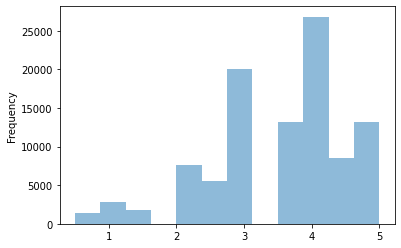

In [31]:
ratings.rating.plot.hist(bins=12, alpha=0.5)

In [33]:
ratings.rating.describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Let's see if the ID's in `movieId` column are the same as in the `movies` DataFrame

In [36]:
assert len([_id for _id in ratings.movieId.values if _id not in movies.movieId.values]) == 0, "Some ID's don't match!!"

That's good

Now we will see if there're repeated reviews made by the same user

In [43]:
assert len(ratings[ratings.duplicated()]) == 0, "There're duplicated rows in the ratings data!"

In [46]:
assert len(ratings[ratings.duplicated(subset=['userId','movieId'])]) == 0, "There're duplicated reviews"

#### Tags

In [39]:
tags.head(2)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996


In [25]:
len(tags.movieId.unique())

1572

Let's check that the movies ID's are the same as before

In [37]:
assert len([_id for _id in tags.movieId.values if _id not in movies.movieId.values]) == 0, "Some ID's don't match!!"

And let's do the same with the User ID's

In [38]:
assert len([_id for _id in tags.userId.values if _id not in ratings.userId.values]) == 0, "Some ID's don't match!!"

### Enter the Matrix

In [47]:
movies.shape

(9742, 4)

In [49]:
len(ratings.userId.unique())

610

#### Let's now build a matrix with `n=610` rows (one per each user) and `m=9742` columns (one per movie)

In [65]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [75]:
reviews_df = ratings[['userId', 'movieId', 'rating']].pivot(*['userId', 'movieId', 'rating']).fillna(-1.)

In [76]:
reviews_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,-1.0,4.0,-1.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


Et Voilà

In [78]:
reviews_df.to_csv('../data/ml-latest-small/review_matrix.csv')